In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import optuna
import lightgbm as lgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import GlorotUniform


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

In [2]:
def load_data(file_path):
    with open(file_path) as f:
        df = pd.read_csv(f)
        return df


train_df, val_df = train_test_split(
    load_data("train.csv"), test_size=0.2, random_state=42
)

test_df = load_data("test.csv")

In [3]:
numerical_features = train_df.select_dtypes(include=["int64", "float64"]).columns
categorical_features = train_df.select_dtypes(include=["object"]).columns

print(f"Numerical features length: {len(numerical_features)}")
print(f"Categorical features lenght: {len(categorical_features)}")

Numerical features length: 38
Categorical features lenght: 43


# Problem

We havea a dataset with real estate data, and our goal is to create a model which predicts the Sale Price of a house based on its characteristics. A secondary objective is to determine which characteristics most significantly influence it.


## Variables


We have 80 variables, with a mix of variable types.

Our **Target Variable** is `SalePrice` which is a continuous variable


### Recap


#### Variable types

- Ordinal Variables

  - OverallQual (overall material and finish of the house)
  - OverallCond (overall condition of the house)

- Categorical Variables:

  - MSZoning (zone)
  - Street (type of road access)
  - SaleCondition (condition of sale)
  - Alley (type of alley access to the house, if any)

- Numerical Variables

  - Discrete:

    - BedroomAbvGr (number of bedrooms above ground level)
    - FullBath (number of bathrooms)
    - GarageCars (size of garage in car capacity.)

  - Continuous:
    - LotFrontage (linear feet of street connected to the property)
    - LotArea (lot size in square feet)
    - SalePrice (sale price of the property)


# Evaluating and Preparing the dataset


In [4]:
print(train_df.head())

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
254    255          20       RL         70.0     8400   Pave   NaN      Reg   
1066  1067          60       RL         59.0     7837   Pave   NaN      IR1   
638    639          30       RL         67.0     8777   Pave   NaN      Reg   
799    800          50       RL         60.0     7200   Pave   NaN      Reg   
380    381          50       RL         50.0     5000   Pave  Pave      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
254          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1066         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
638          Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
799          Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
380          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  

### Check for missing values


In [5]:
def summarize_data(df):
    print("Data Shape:", df.shape)
    # print the first 20 value missing values in descending order
    print("\nMissing Values:\n", df.isnull().sum().sort_values(ascending=False)[:20])
    print("\nBasic Statistics:\n", df.describe())


summarize_data(train_df)
# summarize_data(test_df)

Data Shape: (1168, 81)

Missing Values:
 PoolQC          1162
MiscFeature     1122
Alley           1094
Fence            935
FireplaceQu      547
LotFrontage      217
GarageYrBlt       64
GarageCond        64
GarageType        64
GarageFinish      64
GarageQual        64
BsmtQual          28
BsmtCond          28
BsmtFinType2      28
BsmtFinType1      28
BsmtExposure      28
MasVnrArea         6
MasVnrType         6
Electrical         1
Id                 0
dtype: int64

Basic Statistics:
                 Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1168.000000  1168.000000   951.000000    1168.000000  1168.000000   
mean    730.904966    56.849315    70.343849   10689.642123     6.121575   
std     425.369088    42.531862    24.897021   10759.366198     1.367619   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     360.750000    20.000000    59.000000    7587.250000     5.000000   
50%     732.500000    50.000000    70.000000    96

array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>],
       [<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>],
       [<Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,

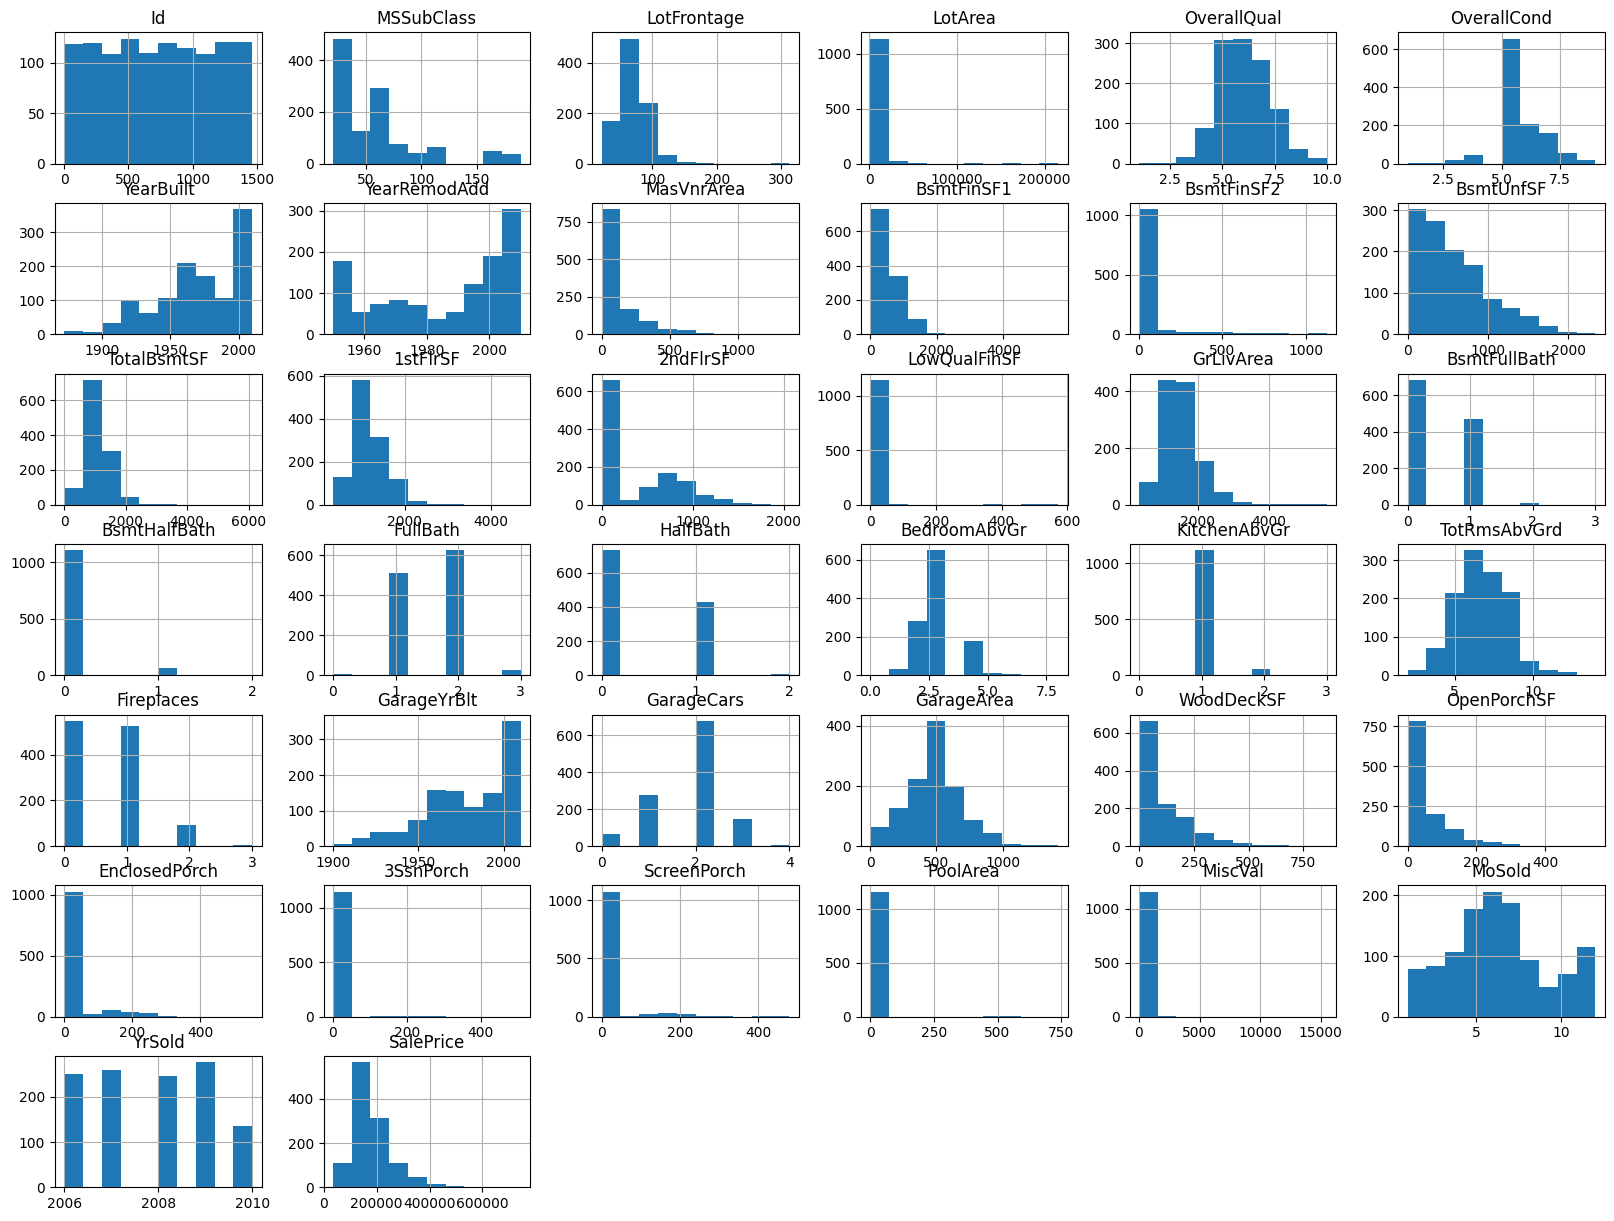

In [6]:
train_df.hist(figsize=(20, 15))

## Principal Component Analysis (PCA)


For the Numerical:

- We will remove the rows with missing values in the `MasVnrArea` column. Additionally, we will drop the columns `LotFrontage` and `GarageYrBlt`

For the Categorical:

- We will drop the columns `Alley`, `PoolQC`, `Fence`, `MiscFeature`, `FireplaceQu`, `GarageType`, `GarageFinish`, `GarageQual`, and `GarageCond` as they have more than 50% of missing values


In [7]:
def handle_missing_data(df, columns_to_drop, threshold=0.5):
    df = df.drop(columns=columns_to_drop)
    threshold_value = threshold * len(df)
    df = df.dropna(thresh=threshold_value, axis=1)

    df = df.dropna()
    return df


missing_values_columns = [
    "Alley",
    "PoolQC",
    "Fence",
    "MiscFeature",
    "LotFrontage",
    "GarageYrBlt",
    "FireplaceQu",
    "GarageType",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
]

train_df = handle_missing_data(train_df, columns_to_drop=missing_values_columns)
train_target = train_df["SalePrice"]
train_df.drop(columns=["SalePrice"], inplace=True)

val_df = handle_missing_data(val_df, columns_to_drop=missing_values_columns)
val_target = val_df["SalePrice"]
val_df.drop(columns=["SalePrice"], inplace=True)

print(train_df.shape)

(1133, 69)


### Numerical Feature Scaling


In [8]:
def scale_numerical_features(df):
    numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns
    print(numerical_cols)
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    print(df.shape)
    return df[numerical_cols]


scaled_numerical_train_df = scale_numerical_features(train_df)
scaled_numerical_val_df = scale_numerical_features(val_df)

print(scaled_numerical_train_df.index)

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
(1133, 69)
Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
    

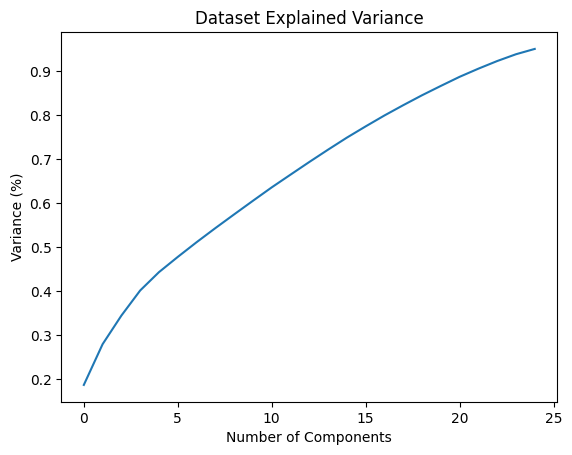

Number of Principal Components selected: 25 

[0.18730746 0.27985984 0.34481704 0.40181326 0.44341231 0.47795664
 0.51130148 0.54335273 0.57454868 0.60542596 0.63587405 0.66475799
 0.6935129  0.72154317 0.7488317  0.774383   0.79916683 0.82251619
 0.84504526 0.86624826 0.88692869 0.905441   0.92275268 0.93820044
 0.95029551] 

[6.5615525  3.24219469 2.27551047 1.99662992 1.45725312 1.21011968
 1.16810032 1.12278448 1.09282279 1.08165957 1.06662469 1.01183086
 1.00731097 0.98192598 0.95594249 0.89508555 0.86820024 0.81794942
 0.78921424 0.74276051 0.72445421 0.6485035  0.606444   0.54114926
 0.42370118] 

[[-3.88828368e-04 -1.13760166e-02  1.15761460e-01  3.07211293e-01
  -8.87404966e-02  2.24151073e-01  1.99663502e-01  2.09215125e-01
   1.28785199e-01 -1.04618252e-02  1.25067924e-01  2.72965528e-01
   2.74956894e-01  1.44174227e-01 -7.12215096e-03  3.22333246e-01
   6.27029499e-02 -2.43388527e-02  2.79388540e-01  1.25273688e-01
   1.21746757e-01  5.18841312e-03  2.61386697e-01  1.92866

In [9]:
def pca_analysis(pca, plot=True):
    # Cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Eigenvalues
    eigenvalues = pca.explained_variance_

    # Loadings
    loadings = pca.components_

    # Number of principal components selected
    num_components_selected = len(pca.explained_variance_ratio_)

    # Scree plot
    if plot:
        plt.figure()
        plt.plot(cumulative_variance)
        plt.xlabel("Number of Components")
        plt.ylabel("Variance (%)")
        plt.title("Dataset Explained Variance")
        plt.show()

    return {
        "num_components": num_components_selected,
        "cumulative_variance": cumulative_variance,
        "eigenvalues": eigenvalues,
        "loadings": loadings,
    }


def apply_pca(df, n_components=0.95):
    pca = PCA(n_components=n_components)
    original_index = df.index
    principal_components = pca.fit_transform(df)
    col_names = [f"PC{i+1}" for i in range(principal_components.shape[1])]
    pca_df = pd.DataFrame(principal_components, columns=col_names)
    pca_df.index = original_index
    return pca_df, pca


# Applying PCA to train and test dataframes
pca_train_df, pca_train = apply_pca(scaled_numerical_train_df)
pca_val_df = pca_train.transform(scaled_numerical_val_df)

# Now use the trained PCA object for analysis
pca_metrics = pca_analysis(pca_train)
print(f"Number of Principal Components selected: {pca_metrics['num_components']} \n")
print(f"{pca_metrics['cumulative_variance']} \n")
print(f"{pca_metrics['eigenvalues']} \n")
print(pca_metrics["loadings"])

### Categorical Feature Scaling


In [10]:
def one_hot_encode(df, drop_first=True):
    categorical_cols = df.select_dtypes(include=["object"]).columns
    categorical_df = pd.get_dummies(df[categorical_cols], drop_first=drop_first)
    return categorical_df


categorical_df_train = one_hot_encode(train_df)
categorical_df_val = one_hot_encode(val_df)

print(categorical_df_val.shape)
print(categorical_df_val.index)

(279, 146)
Int64Index([ 892, 1105,  413,  522, 1036,  614,  218, 1160,  649,  887,
            ...
             989,  677,  478, 1271, 1410,  479, 1361,  802,  651,  722],
           dtype='int64', length=279)


In [11]:
# Transorm the numpy array to dataframe
pca_val_df = pd.DataFrame(pca_val_df, index=val_df.index)

merged_train_df = pd.concat([pca_train_df, categorical_df_train], axis=1)
merged_val_df = pd.concat([pca_val_df, categorical_df_val], axis=1)
# change the name of the int column names to PCs, just the int if string no
merged_val_df.columns = [
    f"PC{i+1}" if isinstance(i, int) else i for i in merged_val_df.columns
]

merged_train_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
254,-2.004940,-1.969061,1.279698,0.382698,0.705067,-0.439107,0.825323,-1.228508,0.327161,-0.111389,...,0,0,0,0,1,0,0,0,1,0
1066,-0.095856,1.884242,-1.200215,-0.843018,-0.946184,-0.931341,0.712817,-0.232444,-0.381402,-0.384022,...,0,0,0,0,1,0,0,0,1,0
638,-5.023612,0.083955,0.502387,1.602325,-0.636812,-0.740043,1.173862,0.373158,0.387228,-0.859035,...,0,0,0,0,1,0,0,0,1,0
799,-1.758107,1.558404,3.118459,-0.420086,-0.310257,-1.090482,-0.706323,0.534387,1.572585,-2.416216,...,0,0,0,0,1,0,0,0,1,0
380,-2.107909,1.663698,1.057856,1.857066,0.246435,-1.910081,0.638237,-0.243300,1.003140,-0.968574,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0.372652,-0.518971,-2.161429,1.733377,-0.211678,-0.609505,0.053255,0.595282,-0.402895,-0.072663,...,0,0,0,0,1,0,0,0,1,0
1130,0.886430,0.347105,1.953325,0.461941,1.074213,0.998613,-0.718700,-0.410995,-1.019799,-1.471926,...,0,0,0,0,1,0,0,0,1,0
1294,-2.431624,-1.353853,-0.766398,0.146881,-0.252238,-0.131335,0.408691,1.393184,-0.192519,-0.749475,...,0,0,0,0,1,0,0,0,1,0
860,-1.114858,2.052534,-0.062047,0.091398,-2.196402,-0.391619,0.010450,0.664780,0.269019,0.616765,...,0,0,0,0,1,0,0,0,1,0


# Selection of the appropriate model

I will try a few:

- Linear Regression
- Decision Tree
- Random Forest Tree
- LightGBM Regressor
- Neural Network


ensure the two dfs have the same columns


In [41]:
common_cols = set(merged_train_df.columns).intersection(set(merged_val_df.columns))
merged_train_df = merged_train_df[common_cols]
merged_val_df = merged_val_df[common_cols]
print(merged_train_df.columns.equals(merged_val_df.columns))

True


/var/folders/3g/5z5sh5l968zfhsm0b7025f_h0000gn/T/ipykernel_2829/1627650064.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  merged_train_df = merged_train_df[common_cols]
/var/folders/3g/5z5sh5l968zfhsm0b7025f_h0000gn/T/ipykernel_2829/1627650064.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  merged_val_df = merged_val_df[common_cols]


In [13]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    print("MAE:", round(mean_absolute_error(y_test, predictions)))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_test, predictions))))
    print("R2 Score:", format(r2_score(y_test, predictions), ".2f"))

    return predictions


def plot_actual_vs_predicted(train_target, predicted_values):
    plt.scatter(train_target, predicted_values)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted Values")
    plt.show()

## Linear Regression


#### Train model


In [14]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(merged_train_df, train_target)


l_regression_predictions_train = evaluate_model(
    linear_regression_model, merged_train_df, train_target
)

MAE: 16245
RMSE: 25375
R2 Score: 0.89


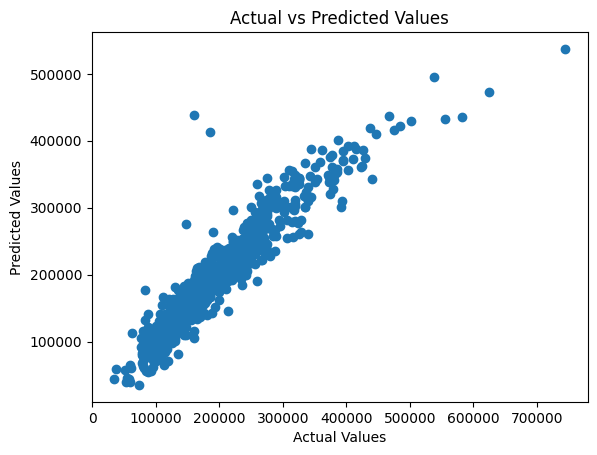

In [15]:
plot_actual_vs_predicted(train_target, l_regression_predictions_train)

#### Test the model


MAE: 21993
RMSE: 32469
R2 Score: 0.86


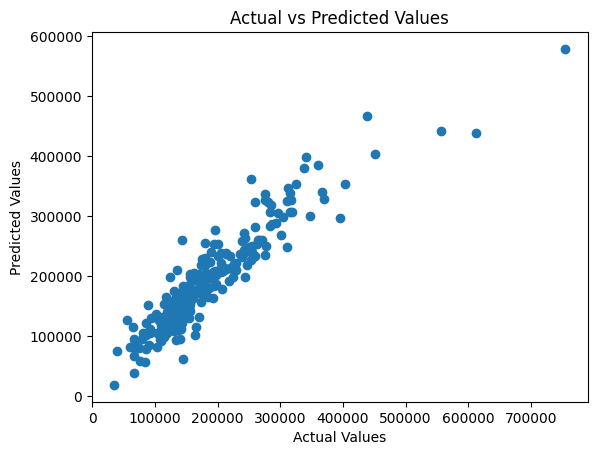

In [16]:
l_regression_val_predictions = evaluate_model(
    linear_regression_model, merged_val_df, val_target
)

plot_actual_vs_predicted(val_target, l_regression_val_predictions)

## Decision Trees


### Train


In [17]:
dt_regressor_model = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
)

dt_regressor_model.fit(merged_train_df, train_target)
dt_predictions_train = evaluate_model(dt_regressor_model, merged_train_df, train_target)

MAE: 6197
RMSE: 9914
R2 Score: 0.98


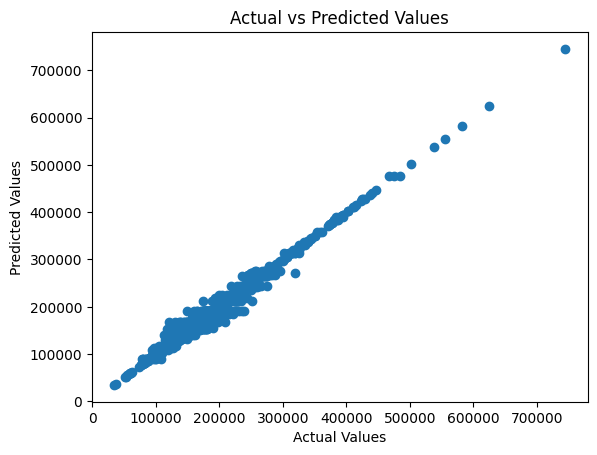

In [18]:
plot_actual_vs_predicted(train_target, dt_predictions_train)

### Test


In [19]:
dt_predictions_val = evaluate_model(dt_regressor_model, merged_val_df, val_target)

MAE: 26836
RMSE: 41141
R2 Score: 0.78


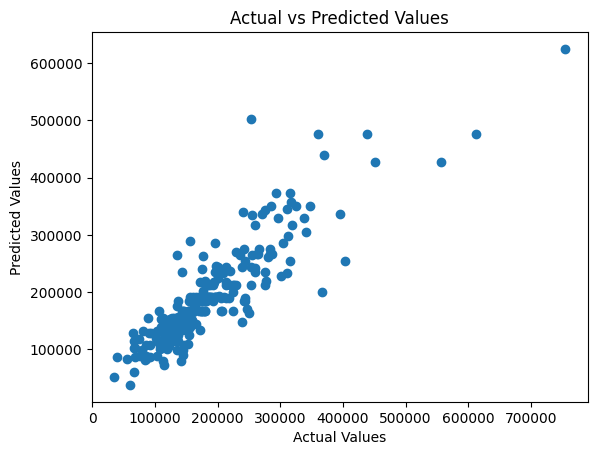

In [20]:
plot_actual_vs_predicted(val_target, dt_predictions_val)

### Hyperparameters Optimization

In [21]:
def objective(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 150),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 60),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "criterion": trial.suggest_categorical(
            "criterion", ["friedman_mse", "poisson", "absolute_error", "squared_error"]
        ),
    }

    model = DecisionTreeRegressor(**param)

    """
    In case the overfit too much on the training we can use cross validation to get a better estimate of the model performance
    """
    # scores = cross_val_score(
    #     model,
    #     merged_train_df,
    #     train_target,
    #     n_jobs=-1,
    #     cv=5,
    #     scoring="neg_mean_squared_error",
    # )

    # return -scores.mean()

    model.fit(merged_train_df, train_target)
    preds = model.predict(merged_train_df)
    mse = mean_squared_error(train_target, preds)

    return mse


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)

[I 2024-02-28 09:49:46,380] A new study created in memory with name: no-name-0ed545e5-03e7-4cf9-ac61-3f96fd3f43ca
[I 2024-02-28 09:49:46,385] Trial 0 finished with value: 4823938203.630312 and parameters: {'max_depth': 3, 'min_samples_split': 116, 'min_samples_leaf': 40, 'max_features': 'log2', 'criterion': 'squared_error'}. Best is trial 0 with value: 4823938203.630312.
[I 2024-02-28 09:49:46,390] Trial 1 finished with value: 3403839030.127295 and parameters: {'max_depth': 3, 'min_samples_split': 28, 'min_samples_leaf': 18, 'max_features': 'sqrt', 'criterion': 'poisson'}. Best is trial 1 with value: 3403839030.127295.
[I 2024-02-28 09:49:46,406] Trial 2 finished with value: 4228030729.2947927 and parameters: {'max_depth': 3, 'min_samples_split': 141, 'min_samples_leaf': 57, 'max_features': 'log2', 'criterion': 'absolute_error'}. Best is trial 1 with value: 3403839030.127295.
[I 2024-02-28 09:49:46,409] Trial 3 finished with value: 3922575806.206759 and parameters: {'max_depth': 4, 'mi

Number of finished trials: 100
Best trial: {'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'squared_error'}


### Optimized Train and Test

In [22]:
optimized_dt_regressor_model = DecisionTreeRegressor(**study.best_params)
optimized_dt_regressor_model.fit(merged_train_df, train_target)

print("\nTRAIN\n")
evaluate_model(optimized_dt_regressor_model, merged_train_df, train_target)

print("\nTEST\n")
evaluate_model(optimized_dt_regressor_model, merged_val_df, val_target)


TRAIN

MAE: 28050
RMSE: 40725
R2 Score: 0.72

TEST

MAE: 39693
RMSE: 68526
R2 Score: 0.38


array([147450.1441048 , 258101.85714286, 114445.45454545, 146700.        ,
       322034.875     ,  85625.        , 206533.33333333, 158558.23376623,
        85625.        , 117494.68085106, 147450.1441048 , 147450.1441048 ,
       114445.45454545, 212820.47337278, 212820.47337278, 150065.38461538,
       212820.47337278, 147450.1441048 , 114445.45454545, 212820.47337278,
       147450.1441048 , 212820.47337278, 212820.47337278, 147450.1441048 ,
       212820.47337278, 146390.81481481, 212820.47337278, 124666.66666667,
       212820.47337278, 205994.84615385, 147450.1441048 , 212820.47337278,
       147450.1441048 ,  97500.        , 212820.47337278, 147450.1441048 ,
       125633.33333333, 212820.47337278, 189977.94117647, 301750.        ,
       190875.        , 147450.1441048 , 322034.875     , 147450.1441048 ,
        86518.75      , 147450.1441048 , 147450.1441048 , 146700.        ,
       147450.1441048 , 147450.1441048 , 224333.33333333,  85625.        ,
       264487.5       , 1

## Random Forest Regressor


In [23]:
random_forest_regressor = RandomForestRegressor(n_estimators=1000, random_state=50)

random_forest_regressor.fit(merged_train_df, train_target)
rf_predictions_train = evaluate_model(
    random_forest_regressor, merged_train_df, train_target
)

MAE: 6661
RMSE: 11830
R2 Score: 0.98


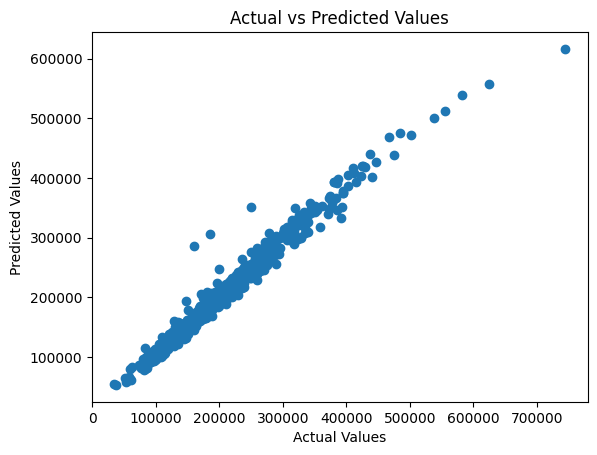

In [24]:
plot_actual_vs_predicted(train_target, rf_predictions_train)

MAE: 19050
RMSE: 31826
R2 Score: 0.87


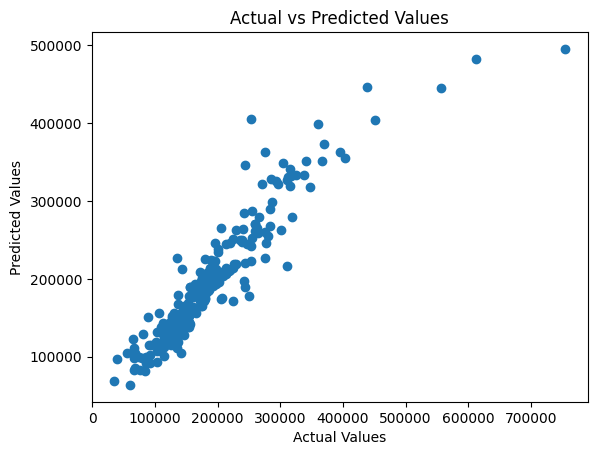

In [25]:
rf_predictions_val = evaluate_model(
    random_forest_regressor, merged_val_df, val_target
)

plot_actual_vs_predicted(val_target, rf_predictions_val)

### Optimize Hyperparameters

In [26]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "max_depth": trial.suggest_int("max_depth", 2, 15),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 150),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 60),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "criterion": trial.suggest_categorical(
            "criterion", ["squared_error", "absolute_error", "poisson", "friedman_mse"]
        ),
    }

    model = RandomForestRegressor(**param)
    model.fit(merged_train_df, train_target)

    preds = model.predict(merged_train_df)

    mse = mean_squared_error(train_target, preds)

    return mse


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_params)

[I 2024-02-28 09:50:05,970] A new study created in memory with name: no-name-7242fb52-48ea-4591-ab74-0aa5450db8ed
[I 2024-02-28 09:50:06,825] Trial 0 finished with value: 2494712985.0084968 and parameters: {'n_estimators': 974, 'max_depth': 5, 'min_samples_split': 53, 'min_samples_leaf': 43, 'max_features': 'sqrt', 'criterion': 'friedman_mse'}. Best is trial 0 with value: 2494712985.0084968.
[I 2024-02-28 09:50:08,886] Trial 1 finished with value: 3093697846.805481 and parameters: {'n_estimators': 351, 'max_depth': 4, 'min_samples_split': 45, 'min_samples_leaf': 17, 'max_features': 'log2', 'criterion': 'absolute_error'}. Best is trial 0 with value: 2494712985.0084968.
[I 2024-02-28 09:50:09,988] Trial 2 finished with value: 2279648139.3074307 and parameters: {'n_estimators': 1378, 'max_depth': 15, 'min_samples_split': 62, 'min_samples_leaf': 15, 'max_features': 'log2', 'criterion': 'squared_error'}. Best is trial 2 with value: 2279648139.3074307.
[I 2024-02-28 09:50:11,038] Trial 3 fin

Number of finished trials: 100
Best trial: {'n_estimators': 459, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'friedman_mse'}


### Optimized Train and Test

In [27]:
optimized_rforest = RandomForestRegressor(**study.best_params)
optimized_rforest.fit(merged_train_df, train_target)

print("\nTRAIN\n")
evaluate_model(optimized_rforest, merged_train_df, train_target)

print("\nTEST\n")
evaluate_model(optimized_rforest, merged_val_df, val_target)


TRAIN

MAE: 9539
RMSE: 14726
R2 Score: 0.96

TEST

MAE: 22576
RMSE: 41194
R2 Score: 0.77


array([143815.29722587, 292406.97483889, 113665.45698041, 142921.55195698,
       315194.35786049, 105564.37419386, 204074.30779946, 158680.89654526,
       107987.23116327, 143872.27034429, 141375.76858235, 128323.45327169,
       135695.9422209 , 221918.76548082, 179808.84947518, 137622.54448701,
       202655.3783314 , 134013.83264897, 118529.73081328, 230370.01781315,
       158155.05733174, 199950.19999997, 201969.74366749, 136818.77648448,
       214083.15760677, 185509.4680568 , 200074.45143663, 122358.96655761,
       177418.11663422, 216116.71271703, 135022.35050727, 274048.17290526,
       207492.21661926, 123587.32620863, 245147.75932975, 148000.92609083,
       139997.85064933, 211445.54931952, 282114.3802208 , 135839.6900114 ,
       247552.05860495, 125509.42385141, 343005.60806975, 136520.07514257,
       141928.19310681, 129891.75405206, 131897.14522524, 325691.05771616,
       138982.12863179, 127691.69363396, 206513.34897396, 131921.1015213 ,
       262757.79561862, 1

## Ensemble method: LightGMB Regressor


In [28]:
cat_train = train_df.columns[train_df.dtypes == "object"]
cat_val = val_df.columns[val_df.dtypes == "object"]

for id in cat_train:
    train_df[id] = train_df[id].astype("category")

for id in cat_val:
    val_df[id] = val_df[id].astype("category")


lgb_train = lgb.Dataset(train_df, train_target)
lgb_val = lgb.Dataset(val_df, val_target)

In [29]:
val_df.dtypes

Id                float64
MSSubClass        float64
MSZoning         category
LotArea           float64
Street           category
                   ...   
MiscVal           float64
MoSold            float64
YrSold            float64
SaleType         category
SaleCondition    category
Length: 69, dtype: object

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3186
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 65
[LightGBM] [Info] Start training from score 183227.541041
MAE: 2367
RMSE: 5819
R2 Score: 0.99


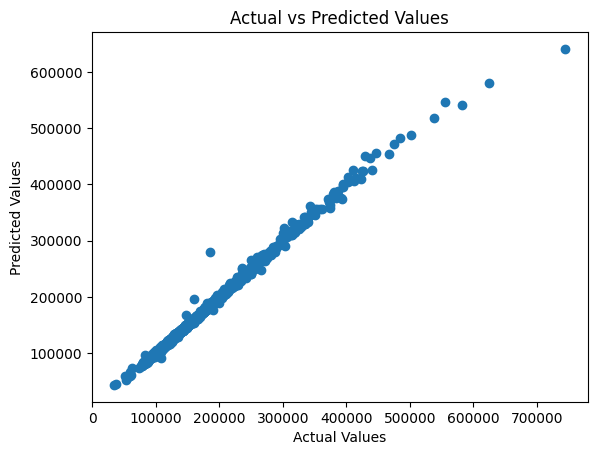

In [43]:
params = {
    "objective": "regression",
    "metric": "rmse",
    # "num_leaves": 30,
    # "learning_rate": 0.05,
    # "verbose": 0,
}

lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=200,
    # valid_sets=[lgb_train, lgb_val],
    # early_stopping_rounds=100,
    # verbose_eval=100,
)


lgb_predictions_train = evaluate_model(lgb_model, train_df, train_target)

plot_actual_vs_predicted(train_target, lgb_predictions_train)

MAE: 17210
RMSE: 28535
R2 Score: 0.89


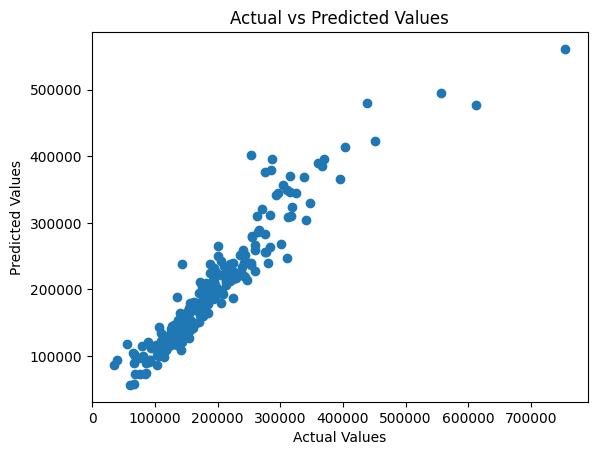

In [31]:
lgb_predictions_val = evaluate_model(lgb_model, val_df, val_target)

plot_actual_vs_predicted(val_target, lgb_predictions_val)

### Optimize Hyperparameters

In [44]:
def objective(trial):
    param = {
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": trial.suggest_int("num_leaves", 10, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
        "verbose": -1,
        "random_state": 42  # Fixed seed for reproducibility
    }

    callbacks = [
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100),
    ]

    lgb_model = lgb.train(
        param,
        lgb_train,
        num_boost_round=200,
        valid_sets=[lgb_val],
        callbacks=callbacks,
    )

    preds = lgb_model.predict(val_df, num_iteration=lgb_model.best_iteration)
    mse = mean_squared_error(val_target, preds)

    return mse

# Fixed seed for Optuna
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)

[I 2024-02-28 10:19:09,092] A new study created in memory with name: no-name-d91f4b32-d9bb-4bd5-af8a-7af0bb04ebdd


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28475.6


[I 2024-02-28 10:19:10,350] Trial 0 finished with value: 791458901.7494004 and parameters: {'num_leaves': 44, 'learning_rate': 0.0951207163345817, 'max_depth': 38, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 0.15599452033620265}. Best is trial 0 with value: 791458901.7494004.


[200]	valid_0's rmse: 28197.7
Did not meet early stopping. Best iteration is:
[152]	valid_0's rmse: 28132.9
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29125.9


[I 2024-02-28 10:19:10,865] Trial 1 finished with value: 818556704.4651943 and parameters: {'num_leaves': 15, 'learning_rate': 0.08675143843171859, 'max_depth': 32, 'subsample': 0.8540362888980227, 'colsample_bytree': 0.5102922471479012, 'reg_alpha': 0.9699098521619943}. Best is trial 0 with value: 791458901.7494004.


[200]	valid_0's rmse: 28732.2
Did not meet early stopping. Best iteration is:
[176]	valid_0's rmse: 28610.4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 33996.5


[I 2024-02-28 10:19:11,803] Trial 2 finished with value: 904232079.5993665 and parameters: {'num_leaves': 85, 'learning_rate': 0.022021571957149343, 'max_depth': 13, 'subsample': 0.5917022549267169, 'colsample_bytree': 0.6521211214797689, 'reg_alpha': 0.5247564316322378}. Best is trial 0 with value: 791458901.7494004.


[200]	valid_0's rmse: 30070.5
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 30070.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 31504.4


[I 2024-02-28 10:19:12,750] Trial 3 finished with value: 860303440.566763 and parameters: {'num_leaves': 49, 'learning_rate': 0.029831684879606152, 'max_depth': 33, 'subsample': 0.569746930326021, 'colsample_bytree': 0.6460723242676091, 'reg_alpha': 0.3663618432936917}. Best is trial 0 with value: 791458901.7494004.


[200]	valid_0's rmse: 29346.3
Did not meet early stopping. Best iteration is:
[197]	valid_0's rmse: 29330.9
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29825.4


[I 2024-02-28 10:19:13,509] Trial 4 finished with value: 861623910.6434879 and parameters: {'num_leaves': 51, 'learning_rate': 0.07873242017790835, 'max_depth': 14, 'subsample': 0.7571172192068059, 'colsample_bytree': 0.7962072844310213, 'reg_alpha': 0.046450412719997725}. Best is trial 0 with value: 791458901.7494004.


[200]	valid_0's rmse: 29426.1
Did not meet early stopping. Best iteration is:
[173]	valid_0's rmse: 29353.4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 36716.6


[I 2024-02-28 10:19:14,141] Trial 5 finished with value: 972002342.1192129 and parameters: {'num_leaves': 65, 'learning_rate': 0.017881888245041864, 'max_depth': 7, 'subsample': 0.9744427686266666, 'colsample_bytree': 0.9828160165372797, 'reg_alpha': 0.8083973481164611}. Best is trial 0 with value: 791458901.7494004.


[200]	valid_0's rmse: 31177
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 31177
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 46767.7


[I 2024-02-28 10:19:15,005] Trial 6 finished with value: 1193291442.602275 and parameters: {'num_leaves': 37, 'learning_rate': 0.010669539286632005, 'max_depth': 36, 'subsample': 0.7200762468698007, 'colsample_bytree': 0.5610191174223894, 'reg_alpha': 0.4951769101112702}. Best is trial 0 with value: 791458901.7494004.


[200]	valid_0's rmse: 34544.1
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 34544.1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29009.2


[I 2024-02-28 10:19:15,362] Trial 7 finished with value: 802934062.5845368 and parameters: {'num_leaves': 13, 'learning_rate': 0.09102271980579943, 'max_depth': 16, 'subsample': 0.831261142176991, 'colsample_bytree': 0.6558555380447055, 'reg_alpha': 0.5200680211778108}. Best is trial 0 with value: 791458901.7494004.


[200]	valid_0's rmse: 28380.4
Did not meet early stopping. Best iteration is:
[181]	valid_0's rmse: 28336.1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 35648.9


[I 2024-02-28 10:19:16,334] Trial 8 finished with value: 954164127.6633078 and parameters: {'num_leaves': 59, 'learning_rate': 0.01930059109702718, 'max_depth': 49, 'subsample': 0.8875664116805573, 'colsample_bytree': 0.9697494707820946, 'reg_alpha': 0.8948273504276488}. Best is trial 0 with value: 791458901.7494004.


[200]	valid_0's rmse: 30889.5
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 30889.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28592.4


[I 2024-02-28 10:19:16,921] Trial 9 finished with value: 800481053.3889294 and parameters: {'num_leaves': 64, 'learning_rate': 0.09226554926728857, 'max_depth': 9, 'subsample': 0.5979914312095727, 'colsample_bytree': 0.522613644455269, 'reg_alpha': 0.32533033076326434}. Best is trial 0 with value: 791458901.7494004.


[200]	valid_0's rmse: 28292.8
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 28292.8
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29934


[I 2024-02-28 10:19:17,904] Trial 10 finished with value: 836841799.5794376 and parameters: {'num_leaves': 96, 'learning_rate': 0.056326238927489294, 'max_depth': 47, 'subsample': 0.6897100010581731, 'colsample_bytree': 0.8200442512337782, 'reg_alpha': 0.038725199961183066}. Best is trial 0 with value: 791458901.7494004.


[200]	valid_0's rmse: 28962.7
Did not meet early stopping. Best iteration is:
[198]	valid_0's rmse: 28928.2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28893.5


[I 2024-02-28 10:19:18,983] Trial 11 finished with value: 771973378.4269989 and parameters: {'num_leaves': 76, 'learning_rate': 0.06674817841079009, 'max_depth': 24, 'subsample': 0.5038892622502693, 'colsample_bytree': 0.504785716528254, 'reg_alpha': 0.2477745505219334}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 27824.3
Did not meet early stopping. Best iteration is:
[197]	valid_0's rmse: 27784.4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29092.7


[I 2024-02-28 10:19:20,038] Trial 12 finished with value: 786116042.7361634 and parameters: {'num_leaves': 82, 'learning_rate': 0.06448373072656637, 'max_depth': 24, 'subsample': 0.5100211772773494, 'colsample_bytree': 0.5899060127524661, 'reg_alpha': 0.20032328918177933}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28085.4
Did not meet early stopping. Best iteration is:
[195]	valid_0's rmse: 28037.8
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29493.3


[I 2024-02-28 10:19:21,005] Trial 13 finished with value: 830445653.9654646 and parameters: {'num_leaves': 80, 'learning_rate': 0.06493978762962087, 'max_depth': 23, 'subsample': 0.506349620507284, 'colsample_bytree': 0.7343526094439212, 'reg_alpha': 0.25727443663154115}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28821.7
Did not meet early stopping. Best iteration is:
[196]	valid_0's rmse: 28817.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 30276


[I 2024-02-28 10:19:22,018] Trial 14 finished with value: 831396749.31953 and parameters: {'num_leaves': 78, 'learning_rate': 0.041873542531905936, 'max_depth': 24, 'subsample': 0.5091497026860295, 'colsample_bytree': 0.5937663157166836, 'reg_alpha': 0.19702689460412548}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28834
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 28834
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29659.9


[I 2024-02-28 10:19:22,948] Trial 15 finished with value: 843875120.718605 and parameters: {'num_leaves': 100, 'learning_rate': 0.06860825363577, 'max_depth': 20, 'subsample': 0.647700043628328, 'colsample_bytree': 0.700477984841022, 'reg_alpha': 0.6855046081289342}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 29115.8
Did not meet early stopping. Best iteration is:
[168]	valid_0's rmse: 29049.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 30786.3


[I 2024-02-28 10:19:23,989] Trial 16 finished with value: 847616065.4564294 and parameters: {'num_leaves': 74, 'learning_rate': 0.041390079417628595, 'max_depth': 29, 'subsample': 0.5500937553998901, 'colsample_bytree': 0.8888558017534707, 'reg_alpha': 0.43241941160242753}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 29123
Did not meet early stopping. Best iteration is:
[197]	valid_0's rmse: 29113.8
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28863.9


[I 2024-02-28 10:19:25,077] Trial 17 finished with value: 772311096.8938339 and parameters: {'num_leaves': 90, 'learning_rate': 0.06922642647550137, 'max_depth': 42, 'subsample': 0.6427535423572592, 'colsample_bytree': 0.5055982439010099, 'reg_alpha': 0.1409308267618193}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 27820.3
Did not meet early stopping. Best iteration is:
[183]	valid_0's rmse: 27790.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28778.5


[I 2024-02-28 10:19:26,157] Trial 18 finished with value: 798405765.4154801 and parameters: {'num_leaves': 94, 'learning_rate': 0.07750822919345282, 'max_depth': 43, 'subsample': 0.6350288423956711, 'colsample_bytree': 0.5014316299972749, 'reg_alpha': 0.10805132268695096}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28267.7
Did not meet early stopping. Best iteration is:
[175]	valid_0's rmse: 28256.1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29180.4


[I 2024-02-28 10:19:27,235] Trial 19 finished with value: 795302387.4282105 and parameters: {'num_leaves': 90, 'learning_rate': 0.05170349709551212, 'max_depth': 40, 'subsample': 0.6565118598658769, 'colsample_bytree': 0.550665151656877, 'reg_alpha': 0.29786551834661723}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28217.9
Did not meet early stopping. Best iteration is:
[196]	valid_0's rmse: 28201.1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29143.6


[I 2024-02-28 10:19:28,384] Trial 20 finished with value: 816267281.4836991 and parameters: {'num_leaves': 72, 'learning_rate': 0.07686899595973098, 'max_depth': 43, 'subsample': 0.735390947979921, 'colsample_bytree': 0.6331445006802419, 'reg_alpha': 0.6438213784070337}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28737.5
Did not meet early stopping. Best iteration is:
[147]	valid_0's rmse: 28570.4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29352.7


[I 2024-02-28 10:19:29,518] Trial 21 finished with value: 806205007.3335181 and parameters: {'num_leaves': 85, 'learning_rate': 0.06302141244161001, 'max_depth': 26, 'subsample': 0.5342882118634961, 'colsample_bytree': 0.5994406643778878, 'reg_alpha': 0.21330324550393262}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28406.6
Did not meet early stopping. Best iteration is:
[199]	valid_0's rmse: 28393.7
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29698.4


[I 2024-02-28 10:19:30,595] Trial 22 finished with value: 804664449.2058537 and parameters: {'num_leaves': 68, 'learning_rate': 0.04387816832368059, 'max_depth': 20, 'subsample': 0.5973849829742017, 'colsample_bytree': 0.5460436819180146, 'reg_alpha': 0.10375076761535407}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28381.4
Did not meet early stopping. Best iteration is:
[194]	valid_0's rmse: 28366.6
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29210.7


[I 2024-02-28 10:19:31,707] Trial 23 finished with value: 792733438.2148958 and parameters: {'num_leaves': 87, 'learning_rate': 0.05890311376812794, 'max_depth': 28, 'subsample': 0.5031956290320817, 'colsample_bytree': 0.503729923243807, 'reg_alpha': 0.3793229478865642}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28196.4
Did not meet early stopping. Best iteration is:
[184]	valid_0's rmse: 28155.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29408.8


[I 2024-02-28 10:19:32,708] Trial 24 finished with value: 817290902.4929302 and parameters: {'num_leaves': 79, 'learning_rate': 0.07221695189489445, 'max_depth': 19, 'subsample': 0.6194366737502321, 'colsample_bytree': 0.6118675813456883, 'reg_alpha': 0.24728533570739875}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28756.6
Did not meet early stopping. Best iteration is:
[178]	valid_0's rmse: 28588.3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28672.7


[I 2024-02-28 10:19:33,674] Trial 25 finished with value: 800954925.0539674 and parameters: {'num_leaves': 93, 'learning_rate': 0.0819827133070951, 'max_depth': 33, 'subsample': 0.5510164744247467, 'colsample_bytree': 0.7020843771180814, 'reg_alpha': 0.1408298691521338}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28481.3
Did not meet early stopping. Best iteration is:
[147]	valid_0's rmse: 28301.1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29233.4


[I 2024-02-28 10:19:34,773] Trial 26 finished with value: 786217747.4445821 and parameters: {'num_leaves': 60, 'learning_rate': 0.05267895543607294, 'max_depth': 30, 'subsample': 0.6907670542494438, 'colsample_bytree': 0.5465258547556022, 'reg_alpha': 0.01694552464613508}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28143.3
Did not meet early stopping. Best iteration is:
[179]	valid_0's rmse: 28039.6
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29153.7


[I 2024-02-28 10:19:35,868] Trial 27 finished with value: 823286033.53513 and parameters: {'num_leaves': 72, 'learning_rate': 0.07032849549172968, 'max_depth': 23, 'subsample': 0.564939949256398, 'colsample_bytree': 0.690824705798907, 'reg_alpha': 0.17298957854085792}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28729.3
Did not meet early stopping. Best iteration is:
[183]	valid_0's rmse: 28693
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 31182.8


[I 2024-02-28 10:19:36,694] Trial 28 finished with value: 851400053.0071822 and parameters: {'num_leaves': 27, 'learning_rate': 0.03252525239219643, 'max_depth': 26, 'subsample': 0.6768798788897502, 'colsample_bytree': 0.5738259864750574, 'reg_alpha': 0.29215359108580685}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 29178.8
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 29178.8
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28445.1


[I 2024-02-28 10:19:37,795] Trial 29 finished with value: 797284079.2403646 and parameters: {'num_leaves': 84, 'learning_rate': 0.09974951301961636, 'max_depth': 41, 'subsample': 0.7849527378148703, 'colsample_bytree': 0.5821718262630846, 'reg_alpha': 0.11527643609943569}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28348.6
Did not meet early stopping. Best iteration is:
[174]	valid_0's rmse: 28236.2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29094.6


[I 2024-02-28 10:19:38,899] Trial 30 finished with value: 791451916.8984218 and parameters: {'num_leaves': 100, 'learning_rate': 0.06164063803500855, 'max_depth': 37, 'subsample': 0.5324689336899374, 'colsample_bytree': 0.5385577514297871, 'reg_alpha': 0.4296716865754482}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28137.7
Did not meet early stopping. Best iteration is:
[199]	valid_0's rmse: 28132.8
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29236.8


[I 2024-02-28 10:19:40,179] Trial 31 finished with value: 791639521.571874 and parameters: {'num_leaves': 60, 'learning_rate': 0.051265813539540385, 'max_depth': 30, 'subsample': 0.7042476582269456, 'colsample_bytree': 0.5391848967583308, 'reg_alpha': 0.018426143979986657}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28136.1
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 28136.1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29266.9


[I 2024-02-28 10:19:41,282] Trial 32 finished with value: 787813373.6404856 and parameters: {'num_leaves': 41, 'learning_rate': 0.05625609506233777, 'max_depth': 35, 'subsample': 0.7685630528400547, 'colsample_bytree': 0.500646632133284, 'reg_alpha': 0.008230997040238608}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28094.3
Did not meet early stopping. Best iteration is:
[197]	valid_0's rmse: 28068
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28702.2


[I 2024-02-28 10:19:42,418] Trial 33 finished with value: 793483580.464133 and parameters: {'num_leaves': 76, 'learning_rate': 0.08642383474380805, 'max_depth': 17, 'subsample': 0.6136568762910408, 'colsample_bytree': 0.5639792618718953, 'reg_alpha': 0.062317285306182024}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28331.4
Did not meet early stopping. Best iteration is:
[157]	valid_0's rmse: 28168.8
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 30085.7


[I 2024-02-28 10:19:43,558] Trial 34 finished with value: 818261229.6684785 and parameters: {'num_leaves': 58, 'learning_rate': 0.04613157544104643, 'max_depth': 30, 'subsample': 0.6707744594084097, 'colsample_bytree': 0.6134923868822043, 'reg_alpha': 0.17823573159276096}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28605.3
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 28605.3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 30750


[I 2024-02-28 10:19:44,676] Trial 35 finished with value: 845628643.8281653 and parameters: {'num_leaves': 81, 'learning_rate': 0.034924300935403975, 'max_depth': 12, 'subsample': 0.5775420573189276, 'colsample_bytree': 0.5273486372985662, 'reg_alpha': 0.08630475635243443}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 29079.7
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 29079.7
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29262.8


[I 2024-02-28 10:19:45,771] Trial 36 finished with value: 806009140.1081982 and parameters: {'num_leaves': 50, 'learning_rate': 0.06630748484742745, 'max_depth': 32, 'subsample': 0.8316538322481923, 'colsample_bytree': 0.6253565834519307, 'reg_alpha': 0.21112524009725914}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28390.3
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 28390.3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29397.6


[I 2024-02-28 10:19:46,786] Trial 37 finished with value: 829067874.571027 and parameters: {'num_leaves': 69, 'learning_rate': 0.07252826107477299, 'max_depth': 25, 'subsample': 0.9437216189094653, 'colsample_bytree': 0.6690371107272878, 'reg_alpha': 0.35554090737245525}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28863.3
Did not meet early stopping. Best iteration is:
[186]	valid_0's rmse: 28793.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29409


[I 2024-02-28 10:19:47,901] Trial 38 finished with value: 805721459.1476365 and parameters: {'num_leaves': 90, 'learning_rate': 0.05503342171967463, 'max_depth': 22, 'subsample': 0.7316691199517965, 'colsample_bytree': 0.5749485714143737, 'reg_alpha': 0.1342367597421077}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28392.9
Did not meet early stopping. Best iteration is:
[199]	valid_0's rmse: 28385.2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28585


[I 2024-02-28 10:19:48,706] Trial 39 finished with value: 792081548.0821642 and parameters: {'num_leaves': 26, 'learning_rate': 0.08314580272906641, 'max_depth': 46, 'subsample': 0.5816497747607008, 'colsample_bytree': 0.5297049346937389, 'reg_alpha': 0.5954538011129699}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28214.5
Did not meet early stopping. Best iteration is:
[185]	valid_0's rmse: 28143.9
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 30806.7


[I 2024-02-28 10:19:49,684] Trial 40 finished with value: 861569267.4525473 and parameters: {'num_leaves': 53, 'learning_rate': 0.037350205990256555, 'max_depth': 39, 'subsample': 0.532440403000953, 'colsample_bytree': 0.7856856163905419, 'reg_alpha': 0.26916434426880415}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 29352.5
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 29352.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29249.7


[I 2024-02-28 10:19:50,749] Trial 41 finished with value: 800660460.1092527 and parameters: {'num_leaves': 43, 'learning_rate': 0.05907461833073528, 'max_depth': 34, 'subsample': 0.763330162469799, 'colsample_bytree': 0.5114141966374834, 'reg_alpha': 0.025356598439426725}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28319.1
Did not meet early stopping. Best iteration is:
[196]	valid_0's rmse: 28295.9
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29302.4


[I 2024-02-28 10:19:51,767] Trial 42 finished with value: 777358960.9252566 and parameters: {'num_leaves': 38, 'learning_rate': 0.04681450954035504, 'max_depth': 34, 'subsample': 0.8032828267077102, 'colsample_bytree': 0.500086419433231, 'reg_alpha': 0.001056119957623402}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 27886.3
Did not meet early stopping. Best iteration is:
[196]	valid_0's rmse: 27881.2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29619.8


[I 2024-02-28 10:19:52,744] Trial 43 finished with value: 794451074.0417511 and parameters: {'num_leaves': 33, 'learning_rate': 0.04933254142862729, 'max_depth': 31, 'subsample': 0.8755177317500823, 'colsample_bytree': 0.5468614649551187, 'reg_alpha': 0.0498761038852818}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28186
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 28186
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 77891.3


[I 2024-02-28 10:19:53,771] Trial 44 finished with value: 4923468072.9050665 and parameters: {'num_leaves': 46, 'learning_rate': 0.0015403989623539865, 'max_depth': 27, 'subsample': 0.8119636851588734, 'colsample_bytree': 0.5218495550244794, 'reg_alpha': 0.1540644227423213}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 70167.4
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 70167.4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 33541.3


[I 2024-02-28 10:19:54,386] Trial 45 finished with value: 891050757.9373083 and parameters: {'num_leaves': 19, 'learning_rate': 0.02404247086357539, 'max_depth': 37, 'subsample': 0.7991747560333782, 'colsample_bytree': 0.5807061407906167, 'reg_alpha': 0.00182595835076782}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 29850.5
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 29850.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29946.6


[I 2024-02-28 10:19:55,509] Trial 46 finished with value: 828965691.5710727 and parameters: {'num_leaves': 63, 'learning_rate': 0.048882242043582096, 'max_depth': 28, 'subsample': 0.7023308370838355, 'colsample_bytree': 0.8844302319577306, 'reg_alpha': 0.9919564653632482}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28854.8
Did not meet early stopping. Best iteration is:
[190]	valid_0's rmse: 28791.8
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28903.4


[I 2024-02-28 10:19:56,479] Trial 47 finished with value: 809132515.4506013 and parameters: {'num_leaves': 34, 'learning_rate': 0.07504933512034911, 'max_depth': 21, 'subsample': 0.9221997701943301, 'colsample_bytree': 0.5630308248811967, 'reg_alpha': 0.08487073488172658}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28500.7
Did not meet early stopping. Best iteration is:
[174]	valid_0's rmse: 28445.3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28766.1


[I 2024-02-28 10:19:57,652] Trial 48 finished with value: 781547740.8052438 and parameters: {'num_leaves': 82, 'learning_rate': 0.06676666551706628, 'max_depth': 18, 'subsample': 0.850095815889897, 'colsample_bytree': 0.519851715389062, 'reg_alpha': 0.07019331209911639}. Best is trial 11 with value: 771973378.4269989.


[200]	valid_0's rmse: 28032.8
Did not meet early stopping. Best iteration is:
[174]	valid_0's rmse: 27956.2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28931


[I 2024-02-28 10:19:58,850] Trial 49 finished with value: 769351049.7405323 and parameters: {'num_leaves': 89, 'learning_rate': 0.06773472946983568, 'max_depth': 17, 'subsample': 0.8628196465147859, 'colsample_bytree': 0.5203086810370403, 'reg_alpha': 0.22478807553277377}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 27737.2
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 27737.2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28975.8


[I 2024-02-28 10:19:59,833] Trial 50 finished with value: 782396951.1579566 and parameters: {'num_leaves': 88, 'learning_rate': 0.06693189099156892, 'max_depth': 14, 'subsample': 0.8477012073562608, 'colsample_bytree': 0.5204614263504367, 'reg_alpha': 0.8540202414790546}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 28001.8
Did not meet early stopping. Best iteration is:
[197]	valid_0's rmse: 27971.4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29237.7


[I 2024-02-28 10:20:00,631] Trial 51 finished with value: 803344659.1981579 and parameters: {'num_leaves': 90, 'learning_rate': 0.06763961022025673, 'max_depth': 11, 'subsample': 0.8544509708224257, 'colsample_bytree': 0.520681998687113, 'reg_alpha': 0.7520871192152029}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 28367.1
Did not meet early stopping. Best iteration is:
[197]	valid_0's rmse: 28343.3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29099.3


[I 2024-02-28 10:20:01,629] Trial 52 finished with value: 799561564.279339 and parameters: {'num_leaves': 88, 'learning_rate': 0.06082115804222753, 'max_depth': 15, 'subsample': 0.891514370987937, 'colsample_bytree': 0.5006994318363004, 'reg_alpha': 0.904069188426377}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 28356.9
Did not meet early stopping. Best iteration is:
[174]	valid_0's rmse: 28276.5
Training until validation scores don't improve for 100 rounds


[I 2024-02-28 10:20:02,030] Trial 53 finished with value: 810520961.1591337 and parameters: {'num_leaves': 93, 'learning_rate': 0.07336128776575178, 'max_depth': 5, 'subsample': 0.85122107029802, 'colsample_bytree': 0.523326651746156, 'reg_alpha': 0.7961022992078185}. Best is trial 49 with value: 769351049.7405323.


[100]	valid_0's rmse: 29062.1
[200]	valid_0's rmse: 28492.6
Did not meet early stopping. Best iteration is:
[184]	valid_0's rmse: 28469.6
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28774.9


[I 2024-02-28 10:20:03,114] Trial 54 finished with value: 799130675.4701781 and parameters: {'num_leaves': 96, 'learning_rate': 0.08204222002610365, 'max_depth': 17, 'subsample': 0.9118577841381904, 'colsample_bytree': 0.5589465884252213, 'reg_alpha': 0.5557471959467853}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 28367.9
Did not meet early stopping. Best iteration is:
[152]	valid_0's rmse: 28268.9
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29261


[I 2024-02-28 10:20:03,740] Trial 55 finished with value: 809345796.9878365 and parameters: {'num_leaves': 83, 'learning_rate': 0.06536460202063385, 'max_depth': 9, 'subsample': 0.9889767345429508, 'colsample_bytree': 0.6022432430393606, 'reg_alpha': 0.4094726999227902}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 28449
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 28449
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28457.5


[I 2024-02-28 10:20:04,762] Trial 56 finished with value: 786392362.2864454 and parameters: {'num_leaves': 77, 'learning_rate': 0.08891818652226907, 'max_depth': 18, 'subsample': 0.8393938075307966, 'colsample_bytree': 0.5198475286525513, 'reg_alpha': 0.23759587568054064}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 28167.1
Did not meet early stopping. Best iteration is:
[151]	valid_0's rmse: 28042.7
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29116.8


[I 2024-02-28 10:20:05,672] Trial 57 finished with value: 784051477.7637569 and parameters: {'num_leaves': 96, 'learning_rate': 0.06879574248906063, 'max_depth': 14, 'subsample': 0.8069284298786099, 'colsample_bytree': 0.540772069232355, 'reg_alpha': 0.33580630187089444}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 28067.1
Did not meet early stopping. Best iteration is:
[185]	valid_0's rmse: 28000.9
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28816.6


[I 2024-02-28 10:20:06,767] Trial 58 finished with value: 811391726.121553 and parameters: {'num_leaves': 86, 'learning_rate': 0.08029101610503377, 'max_depth': 49, 'subsample': 0.7923577551677803, 'colsample_bytree': 0.5015135340534499, 'reg_alpha': 0.8973905363534316}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 28589.8
Did not meet early stopping. Best iteration is:
[183]	valid_0's rmse: 28484.9
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29187.4


[I 2024-02-28 10:20:07,477] Trial 59 finished with value: 824176536.312299 and parameters: {'num_leaves': 82, 'learning_rate': 0.07776364888463261, 'max_depth': 11, 'subsample': 0.8732431204905585, 'colsample_bytree': 0.6415943889583479, 'reg_alpha': 0.07143098405523292}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 28863.4
Did not meet early stopping. Best iteration is:
[146]	valid_0's rmse: 28708.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29989.3


[I 2024-02-28 10:20:08,310] Trial 60 finished with value: 844695239.6989979 and parameters: {'num_leaves': 73, 'learning_rate': 0.06391505816023044, 'max_depth': 15, 'subsample': 0.9542043008390062, 'colsample_bytree': 0.9413646359971692, 'reg_alpha': 0.4986033003749588}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 29099.5
Did not meet early stopping. Best iteration is:
[195]	valid_0's rmse: 29063.6
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29068.4


[I 2024-02-28 10:20:09,258] Trial 61 finished with value: 808454984.9709823 and parameters: {'num_leaves': 96, 'learning_rate': 0.06954150637674136, 'max_depth': 14, 'subsample': 0.8174815772646438, 'colsample_bytree': 0.5370364214177105, 'reg_alpha': 0.34129575371794196}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 28477.7
Did not meet early stopping. Best iteration is:
[182]	valid_0's rmse: 28433.3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28933.7


[I 2024-02-28 10:20:09,883] Trial 62 finished with value: 791554497.0354196 and parameters: {'num_leaves': 92, 'learning_rate': 0.07020340571964506, 'max_depth': 9, 'subsample': 0.8181957481774311, 'colsample_bytree': 0.5505652089524264, 'reg_alpha': 0.27384446496278025}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 28143.9
Did not meet early stopping. Best iteration is:
[157]	valid_0's rmse: 28134.6
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29318.7


[I 2024-02-28 10:20:10,774] Trial 63 finished with value: 784113716.64998 and parameters: {'num_leaves': 96, 'learning_rate': 0.05660619507524929, 'max_depth': 13, 'subsample': 0.7764233567922063, 'colsample_bytree': 0.5158215444618608, 'reg_alpha': 0.3224950788976748}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 28017.5
Did not meet early stopping. Best iteration is:
[199]	valid_0's rmse: 28002
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29164.2


[I 2024-02-28 10:20:11,846] Trial 64 finished with value: 785484357.9895185 and parameters: {'num_leaves': 86, 'learning_rate': 0.06061812882838813, 'max_depth': 20, 'subsample': 0.8469824635648266, 'colsample_bytree': 0.5611747346224752, 'reg_alpha': 0.21880737175028092}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 28054.9
Did not meet early stopping. Best iteration is:
[184]	valid_0's rmse: 28026.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28723


[I 2024-02-28 10:20:12,201] Trial 65 finished with value: 802399496.1920124 and parameters: {'num_leaves': 10, 'learning_rate': 0.07517456401895159, 'max_depth': 16, 'subsample': 0.8653988071795556, 'colsample_bytree': 0.5328282947617237, 'reg_alpha': 0.18280975748577957}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 28417.4
Did not meet early stopping. Best iteration is:
[195]	valid_0's rmse: 28326.7
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29135.1


[I 2024-02-28 10:20:13,322] Trial 66 finished with value: 799706239.911655 and parameters: {'num_leaves': 99, 'learning_rate': 0.06715093337097666, 'max_depth': 19, 'subsample': 0.7552592372911211, 'colsample_bytree': 0.594270267458036, 'reg_alpha': 0.4556767618526839}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 28279.1
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 28279.1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29744.4


[I 2024-02-28 10:20:14,371] Trial 67 finished with value: 811813782.9554789 and parameters: {'num_leaves': 91, 'learning_rate': 0.05397638250456225, 'max_depth': 43, 'subsample': 0.9095404733365683, 'colsample_bytree': 0.7467813979547294, 'reg_alpha': 0.12479181863552899}. Best is trial 49 with value: 769351049.7405323.


[200]	valid_0's rmse: 28512.7
Did not meet early stopping. Best iteration is:
[195]	valid_0's rmse: 28492.3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28736.6


[I 2024-02-28 10:20:15,494] Trial 68 finished with value: 758054272.4780308 and parameters: {'num_leaves': 88, 'learning_rate': 0.06363528050417736, 'max_depth': 22, 'subsample': 0.8065419072398183, 'colsample_bytree': 0.5114320359373338, 'reg_alpha': 0.3062389603310078}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 27532.8
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 27532.8
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28748.4


[I 2024-02-28 10:20:16,644] Trial 69 finished with value: 786385271.3395485 and parameters: {'num_leaves': 80, 'learning_rate': 0.06319966574662994, 'max_depth': 23, 'subsample': 0.8861761483344014, 'colsample_bytree': 0.5092789374001772, 'reg_alpha': 0.3901761001174492}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28042.6
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 28042.6
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29640.4


[I 2024-02-28 10:20:17,637] Trial 70 finished with value: 821843238.2469859 and parameters: {'num_leaves': 88, 'learning_rate': 0.05764808221941061, 'max_depth': 21, 'subsample': 0.8341154600839251, 'colsample_bytree': 0.8376667760959207, 'reg_alpha': 0.16149954058210303}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28696.9
Did not meet early stopping. Best iteration is:
[191]	valid_0's rmse: 28667.8
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28858


[I 2024-02-28 10:20:18,653] Trial 71 finished with value: 792943928.9679811 and parameters: {'num_leaves': 84, 'learning_rate': 0.0715427057700175, 'max_depth': 18, 'subsample': 0.7421895630907358, 'colsample_bytree': 0.5388310500676957, 'reg_alpha': 0.28841638740108166}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28274.1
Did not meet early stopping. Best iteration is:
[149]	valid_0's rmse: 28159.3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28912.1


[I 2024-02-28 10:20:19,758] Trial 72 finished with value: 799739176.2036581 and parameters: {'num_leaves': 98, 'learning_rate': 0.06752469658592128, 'max_depth': 24, 'subsample': 0.8105540210141227, 'colsample_bytree': 0.5706304455844292, 'reg_alpha': 0.3159296995346733}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28368.5
Did not meet early stopping. Best iteration is:
[178]	valid_0's rmse: 28279.7
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28686.8


[I 2024-02-28 10:20:20,694] Trial 73 finished with value: 775778253.0801934 and parameters: {'num_leaves': 76, 'learning_rate': 0.07488143517421195, 'max_depth': 14, 'subsample': 0.7871697367355431, 'colsample_bytree': 0.5144575137201124, 'reg_alpha': 0.2294165501086997}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 27872.2
Did not meet early stopping. Best iteration is:
[182]	valid_0's rmse: 27852.8
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28898.6


[I 2024-02-28 10:20:21,687] Trial 74 finished with value: 818612660.0615215 and parameters: {'num_leaves': 78, 'learning_rate': 0.08596740709204662, 'max_depth': 16, 'subsample': 0.7806133150519623, 'colsample_bytree': 0.5179259998598231, 'reg_alpha': 0.23885046962783915}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28914.2
Did not meet early stopping. Best iteration is:
[143]	valid_0's rmse: 28611.4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29783.7


[I 2024-02-28 10:20:22,766] Trial 75 finished with value: 820919853.1041573 and parameters: {'num_leaves': 69, 'learning_rate': 0.04563007390808131, 'max_depth': 45, 'subsample': 0.8251413301736192, 'colsample_bytree': 0.5562137231344815, 'reg_alpha': 0.1109240430553623}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28651.7
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 28651.7
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28744.6


[I 2024-02-28 10:20:23,853] Trial 76 finished with value: 780427770.9862547 and parameters: {'num_leaves': 76, 'learning_rate': 0.0748067778089798, 'max_depth': 22, 'subsample': 0.72261271125701, 'colsample_bytree': 0.5015551037023062, 'reg_alpha': 0.04714799071784914}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 27958.6
Did not meet early stopping. Best iteration is:
[196]	valid_0's rmse: 27936.1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28493.2


[I 2024-02-28 10:20:24,937] Trial 77 finished with value: 772928208.2456354 and parameters: {'num_leaves': 68, 'learning_rate': 0.07500114503326842, 'max_depth': 21, 'subsample': 0.6387583859679898, 'colsample_bytree': 0.5006069818261257, 'reg_alpha': 0.0882035333263303}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 27915.5
Did not meet early stopping. Best iteration is:
[181]	valid_0's rmse: 27801.6
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28807.6


[I 2024-02-28 10:20:26,037] Trial 78 finished with value: 803753765.8300383 and parameters: {'num_leaves': 76, 'learning_rate': 0.07935632939856528, 'max_depth': 26, 'subsample': 0.6503916832223274, 'colsample_bytree': 0.5012256666134215, 'reg_alpha': 0.05166927138154838}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28402.3
Did not meet early stopping. Best iteration is:
[176]	valid_0's rmse: 28350.6
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29011.7


[I 2024-02-28 10:20:27,206] Trial 79 finished with value: 810330060.2119857 and parameters: {'num_leaves': 71, 'learning_rate': 0.07528415028457723, 'max_depth': 22, 'subsample': 0.7160572175862052, 'colsample_bytree': 0.532060964503701, 'reg_alpha': 0.19685687202009355}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28527.6
Did not meet early stopping. Best iteration is:
[194]	valid_0's rmse: 28466.3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28737.6


[I 2024-02-28 10:20:28,441] Trial 80 finished with value: 808406612.0642394 and parameters: {'num_leaves': 65, 'learning_rate': 0.084515106387565, 'max_depth': 22, 'subsample': 0.6231806821594951, 'colsample_bytree': 0.551178499210905, 'reg_alpha': 0.1402286464190071}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28543.2
Did not meet early stopping. Best iteration is:
[156]	valid_0's rmse: 28432.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28873.2


[I 2024-02-28 10:20:29,793] Trial 81 finished with value: 787567842.7627524 and parameters: {'num_leaves': 66, 'learning_rate': 0.07339890921858484, 'max_depth': 24, 'subsample': 0.7939893582664026, 'colsample_bytree': 0.5109930106178334, 'reg_alpha': 0.08964527862701141}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28072.4
Did not meet early stopping. Best iteration is:
[198]	valid_0's rmse: 28063.6
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28929.9


[I 2024-02-28 10:20:30,976] Trial 82 finished with value: 793283858.6510009 and parameters: {'num_leaves': 75, 'learning_rate': 0.07727602503402782, 'max_depth': 19, 'subsample': 0.6628485382699554, 'colsample_bytree': 0.5310044920340865, 'reg_alpha': 0.046336605676117526}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28229.3
Did not meet early stopping. Best iteration is:
[194]	valid_0's rmse: 28165.3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29395.5


[I 2024-02-28 10:20:32,207] Trial 83 finished with value: 802859687.0226758 and parameters: {'num_leaves': 56, 'learning_rate': 0.07102168709278685, 'max_depth': 21, 'subsample': 0.6415268178217197, 'colsample_bytree': 0.5106581206388134, 'reg_alpha': 0.03248992627759314}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28334.8
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 28334.8
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29079.5


[I 2024-02-28 10:20:33,296] Trial 84 finished with value: 802299138.5226251 and parameters: {'num_leaves': 71, 'learning_rate': 0.08028730357599113, 'max_depth': 17, 'subsample': 0.7254756878230708, 'colsample_bytree': 0.5127753720014595, 'reg_alpha': 0.10739785104581664}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28335.1
Did not meet early stopping. Best iteration is:
[199]	valid_0's rmse: 28324.9
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28396.6


[I 2024-02-28 10:20:34,350] Trial 85 finished with value: 805156671.7268741 and parameters: {'num_leaves': 81, 'learning_rate': 0.09256419522987465, 'max_depth': 19, 'subsample': 0.7473278600438045, 'colsample_bytree': 0.5001658075441653, 'reg_alpha': 0.15929690020967324}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28548
Did not meet early stopping. Best iteration is:
[104]	valid_0's rmse: 28375.3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29074.8


[I 2024-02-28 10:20:35,434] Trial 86 finished with value: 801966116.9355547 and parameters: {'num_leaves': 80, 'learning_rate': 0.06512747076521204, 'max_depth': 25, 'subsample': 0.6075394557298518, 'colsample_bytree': 0.5271186987425289, 'reg_alpha': 0.22335378998403843}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28332.8
Did not meet early stopping. Best iteration is:
[199]	valid_0's rmse: 28319
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29030


[I 2024-02-28 10:20:36,554] Trial 87 finished with value: 793873573.9685518 and parameters: {'num_leaves': 84, 'learning_rate': 0.07377012646490333, 'max_depth': 41, 'subsample': 0.6893103372615558, 'colsample_bytree': 0.5451588693392656, 'reg_alpha': 0.07616123903739777}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28175.8
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 28175.8
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29035.5


[I 2024-02-28 10:20:37,636] Trial 88 finished with value: 783850845.7425092 and parameters: {'num_leaves': 78, 'learning_rate': 0.060839048197411164, 'max_depth': 27, 'subsample': 0.5232473586655223, 'colsample_bytree': 0.583034726057382, 'reg_alpha': 0.17724084260071205}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28034.7
Did not meet early stopping. Best iteration is:
[196]	valid_0's rmse: 27997.3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29164.7


[I 2024-02-28 10:20:38,726] Trial 89 finished with value: 801090519.9000838 and parameters: {'num_leaves': 62, 'learning_rate': 0.06324754544365825, 'max_depth': 23, 'subsample': 0.7636046359765091, 'colsample_bytree': 0.5677564159447905, 'reg_alpha': 0.0011399740301866884}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28350
Did not meet early stopping. Best iteration is:
[179]	valid_0's rmse: 28303.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29183.8


[I 2024-02-28 10:20:39,800] Trial 90 finished with value: 792268408.833078 and parameters: {'num_leaves': 74, 'learning_rate': 0.058966288073644006, 'max_depth': 25, 'subsample': 0.5581214450151404, 'colsample_bytree': 0.5165066565479481, 'reg_alpha': 0.2579266271148614}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28147.3
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 28147.3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28837.9


[I 2024-02-28 10:20:40,668] Trial 91 finished with value: 792370877.2469577 and parameters: {'num_leaves': 88, 'learning_rate': 0.06606523041570721, 'max_depth': 12, 'subsample': 0.8567613717539844, 'colsample_bytree': 0.527293248521477, 'reg_alpha': 0.6777446955065657}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28164.1
Did not meet early stopping. Best iteration is:
[157]	valid_0's rmse: 28149.1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29930.7


[I 2024-02-28 10:20:41,685] Trial 92 finished with value: 813876424.6458174 and parameters: {'num_leaves': 89, 'learning_rate': 0.039852396508819846, 'max_depth': 15, 'subsample': 0.8380378401226636, 'colsample_bytree': 0.5218902297797489, 'reg_alpha': 0.13172458282173682}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28528.5
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 28528.5
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29290.9


[I 2024-02-28 10:20:42,849] Trial 93 finished with value: 811322853.5664868 and parameters: {'num_leaves': 85, 'learning_rate': 0.06913165930856043, 'max_depth': 18, 'subsample': 0.5858239401471622, 'colsample_bytree': 0.5402412920052218, 'reg_alpha': 0.0945517985300437}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28529.5
Did not meet early stopping. Best iteration is:
[195]	valid_0's rmse: 28483.7
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28833


[I 2024-02-28 10:20:44,043] Trial 94 finished with value: 780370194.8400775 and parameters: {'num_leaves': 82, 'learning_rate': 0.07164480643303262, 'max_depth': 21, 'subsample': 0.8030246236760149, 'colsample_bytree': 0.5100049549302624, 'reg_alpha': 0.19762840626206143}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 27935.1
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 27935.1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28945.3


[I 2024-02-28 10:20:45,129] Trial 95 finished with value: 804332881.9535936 and parameters: {'num_leaves': 83, 'learning_rate': 0.07670793438418644, 'max_depth': 20, 'subsample': 0.7778516341696023, 'colsample_bytree': 0.5005711266189744, 'reg_alpha': 0.1914264158564169}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28379.1
Did not meet early stopping. Best iteration is:
[199]	valid_0's rmse: 28360.8
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28680.9


[I 2024-02-28 10:20:46,213] Trial 96 finished with value: 788510861.7413731 and parameters: {'num_leaves': 68, 'learning_rate': 0.07205915475833752, 'max_depth': 50, 'subsample': 0.6297272652278463, 'colsample_bytree': 0.5113804879629468, 'reg_alpha': 0.06378951402962557}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28095.1
Did not meet early stopping. Best iteration is:
[199]	valid_0's rmse: 28080.4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28912.7


[I 2024-02-28 10:20:47,271] Trial 97 finished with value: 787375613.8070635 and parameters: {'num_leaves': 94, 'learning_rate': 0.07032158473719677, 'max_depth': 21, 'subsample': 0.8003543671581674, 'colsample_bytree': 0.5541029907623605, 'reg_alpha': 0.023850046172666495}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28076.8
Did not meet early stopping. Best iteration is:
[199]	valid_0's rmse: 28060.2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 28697.9


[I 2024-02-28 10:20:48,376] Trial 98 finished with value: 783790883.9873595 and parameters: {'num_leaves': 79, 'learning_rate': 0.08315672851046965, 'max_depth': 22, 'subsample': 0.8279157441602212, 'colsample_bytree': 0.5301527456404485, 'reg_alpha': 0.30428994768328155}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28110.6
Did not meet early stopping. Best iteration is:
[184]	valid_0's rmse: 27996.3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 29440.4


[I 2024-02-28 10:20:49,393] Trial 99 finished with value: 794470719.8723695 and parameters: {'num_leaves': 48, 'learning_rate': 0.047591546856534814, 'max_depth': 20, 'subsample': 0.7854209466213572, 'colsample_bytree': 0.5098181359698295, 'reg_alpha': 0.20839624595123035}. Best is trial 68 with value: 758054272.4780308.


[200]	valid_0's rmse: 28186.4
Did not meet early stopping. Best iteration is:
[200]	valid_0's rmse: 28186.4
Number of finished trials: 100
Best trial: {'num_leaves': 88, 'learning_rate': 0.06363528050417736, 'max_depth': 22, 'subsample': 0.8065419072398183, 'colsample_bytree': 0.5114320359373338, 'reg_alpha': 0.3062389603310078}


### Optimized Train and Test

In [45]:
optimized_lgb = lgb.LGBMRegressor(**study.best_params)
optimized_lgb.fit(train_df, train_target)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3186
[LightGBM] [Info] Number of data points in the train set: 1133, number of used features: 65
[LightGBM] [Info] Start training from score 183227.541041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

array([139166.42246817, 347736.61106408, 114915.3520539 , 170144.51208403,
       316504.01091306,  79946.02301736, 245522.26675071, 148153.11108676,
        80149.03401769, 138233.53798825, 149672.25208803, 129179.68058895,
       120991.87118518, 207849.88032294, 183197.86472351, 135303.51243153,
       206933.47923981, 128421.27374486, 115920.38614509, 228790.70342003,
       167167.22974403, 228689.00618647, 189370.78658908, 126870.62769147,
       215129.7597746 , 168919.21257011, 201796.5091313 , 121649.85898993,
       177381.95981468, 197263.76201845, 118052.31880009, 273299.24463954,
       291414.05572798, 116598.54312672, 293160.60566667, 153756.93835674,
       134044.64204721, 213975.3685845 , 339438.01038433, 129400.73058052,
       232009.69479913, 131507.47095669, 377184.43631179, 129662.04597583,
       126954.85746024, 118813.15913587, 123370.92449575, 433585.10528084,
       143637.43959593, 122456.645584  , 199852.0543424 , 111528.05986496,
       390463.25994084, 1

In [46]:
print("\nTRAIN\n")
evaluate_model(optimized_lgb, train_df, train_target)

print("\nTEST\n")
evaluate_model(optimized_lgb, val_df, val_target)


TRAIN

MAE: 6540
RMSE: 13865
R2 Score: 0.97

TEST

MAE: 17083
RMSE: 29272
R2 Score: 0.89


array([139166.42246817, 347736.61106408, 114915.3520539 , 170144.51208403,
       316504.01091306,  79946.02301736, 245522.26675071, 148153.11108676,
        80149.03401769, 138233.53798825, 149672.25208803, 129179.68058895,
       120991.87118518, 207849.88032294, 183197.86472351, 135303.51243153,
       206933.47923981, 128421.27374486, 115920.38614509, 228790.70342003,
       167167.22974403, 228689.00618647, 189370.78658908, 126870.62769147,
       215129.7597746 , 168919.21257011, 201796.5091313 , 121649.85898993,
       177381.95981468, 197263.76201845, 118052.31880009, 273299.24463954,
       291414.05572798, 116598.54312672, 293160.60566667, 153756.93835674,
       134044.64204721, 213975.3685845 , 339438.01038433, 129400.73058052,
       232009.69479913, 131507.47095669, 377184.43631179, 129662.04597583,
       126954.85746024, 118813.15913587, 123370.92449575, 433585.10528084,
       143637.43959593, 122456.645584  , 199852.0543424 , 111528.05986496,
       390463.25994084, 1

## Neural Network


In [34]:
merged_train_df.shape

(1133, 169)

In [35]:
model_nn = Sequential()
model_nn.add(Dense(128, activation="relu", input_shape=(merged_train_df.shape[1],)))
model_nn.add(Dense(128, activation="relu"))
model_nn.add(Dense(64, activation="relu"))
model_nn.add(Dense(32, activation="relu"))
model_nn.add(Dense(1))

model_nn.compile(optimizer="adam", loss="mean_squared_error")

In [36]:
model_nn.fit(
    merged_train_df,
    train_target,
    validation_data=(merged_val_df, val_target),
    epochs=200,
    batch_size=32,
)

Epoch 1/200
36/36 [==============================] - 0s 4ms/step - loss: 39530434560.0000 - val_loss: 39712419840.0000
Epoch 2/200
36/36 [==============================] - 0s 1ms/step - loss: 38969151488.0000 - val_loss: 37731561472.0000
Epoch 3/200
36/36 [==============================] - 0s 1ms/step - loss: 31651983360.0000 - val_loss: 21540124672.0000
Epoch 4/200
36/36 [==============================] - 0s 1ms/step - loss: 9828552704.0000 - val_loss: 5627014144.0000
Epoch 5/200
36/36 [==============================] - 0s 1ms/step - loss: 3695248640.0000 - val_loss: 3968696320.0000
Epoch 6/200
36/36 [==============================] - 0s 1ms/step - loss: 2706115072.0000 - val_loss: 3102324736.0000
Epoch 7/200
36/36 [==============================] - 0s 1ms/step - loss: 2123055232.0000 - val_loss: 2500145664.0000
Epoch 8/200
36/36 [==============================] - 0s 1ms/step - loss: 1752779520.0000 - val_loss: 2099150464.0000
Epoch 9/200
36/36 [==============================] - 0s 1m

36/36 [==============================] - 0s 539us/step
MAE: 10516
RMSE: 15479
R2 Score: 0.96
36/36 [==============================] - 0s 497us/step


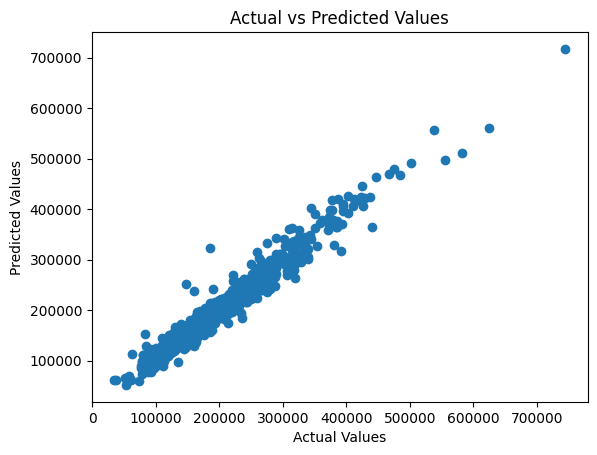

In [37]:
evaluate_model(model_nn, merged_train_df, train_target)
plot_actual_vs_predicted(train_target, model_nn.predict(merged_train_df))

1/9 [==>...........................] - ETA: 0s

9/9 [==============================] - 0s 3ms/step
MAE: 21296
RMSE: 33149
R2 Score: 0.85
9/9 [==============================] - 0s 2ms/step


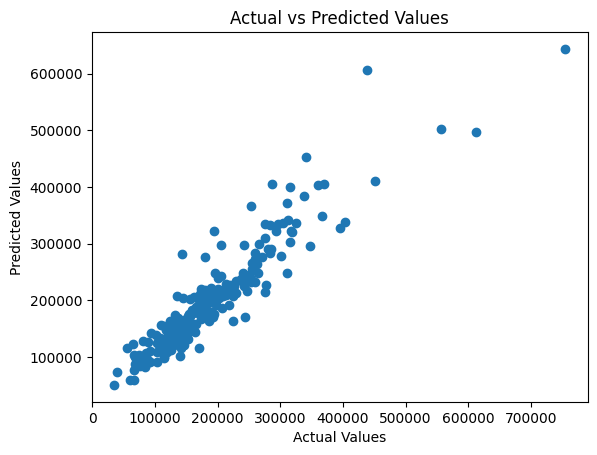

In [38]:
evaluate_model(model_nn, merged_val_df, val_target)
plot_actual_vs_predicted(val_target, model_nn.predict(merged_val_df))

### Optimize the Hyperparameters

In [47]:
def create_model_from_params(params):

    initializer = GlorotUniform(seed=42)

    model = Sequential()
    model.add(
        Dense(
            params["n_units_l0"],
            activation=params["activation_l0"],
            kernel_initializer=initializer,
            input_shape=(merged_train_df.shape[1],),
        )
    )

    # Hidden layers
    for i in range(1, params["n_layers"]):
        model.add(
            Dense(
                params[f"n_units_l{i}"],
                activation=params[f"activation_l{i}"],
                kernel_initializer=initializer,
            )
        )

    model.add(Dense(1, kernel_initializer=initializer))
    model.compile(optimizer=params["optimizer"], loss="mean_squared_error")

    return model


def create_model(trial):
    # Define the hyperparameters
    params = {
        "n_layers": trial.suggest_int("n_layers", 1, 3),
        "n_units_l0": trial.suggest_int("n_units_l0", 4, 128, log=True),
        "activation_l0": trial.suggest_categorical(
            "activation_l0", ["relu", "tanh", "sigmoid"]
        ),
        "optimizer": trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop"]),
    }

    # Adding parameters for additional layers
    for i in range(1, params["n_layers"]):
        params[f"n_units_l{i}"] = trial.suggest_int(f"n_units_l{i}", 4, 128, log=True)
        params[f"activation_l{i}"] = trial.suggest_categorical(
            f"activation_l{i}", ["relu", "tanh", "sigmoid"]
        )

    return create_model_from_params(params)


def objective(trial):
    model = create_model(trial)

    # Adjust the batch size and epochs as necessary
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    epochs = trial.suggest_int("epochs", 1, 20)

    history = model.fit(
        merged_train_df,
        train_target,
        validation_data=(merged_val_df, val_target),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
    )

    val_loss = history.history["val_loss"][-1]
    return val_loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best parameters:", best_params)

[I 2024-02-28 10:39:22,736] A new study created in memory with name: no-name-10eef8ad-b062-4d33-bda1-8827d5043b97
[W 2024-02-28 10:39:23,067] Trial 0 failed with parameters: {'n_layers': 1, 'n_units_l0': 8, 'activation_l0': 'relu', 'optimizer': 'sgd', 'batch_size': 128, 'epochs': 4} because of the following error: The value nan is not acceptable.
[W 2024-02-28 10:39:23,067] Trial 0 failed with value nan.
[I 2024-02-28 10:39:23,926] Trial 1 finished with value: 7753484800.0 and parameters: {'n_layers': 2, 'n_units_l0': 4, 'activation_l0': 'tanh', 'optimizer': 'sgd', 'n_units_l1': 53, 'activation_l1': 'tanh', 'batch_size': 32, 'epochs': 17}. Best is trial 1 with value: 7753484800.0.
[I 2024-02-28 10:39:24,610] Trial 2 finished with value: 39768829952.0 and parameters: {'n_layers': 2, 'n_units_l0': 31, 'activation_l0': 'relu', 'optimizer': 'adam', 'n_units_l1': 28, 'activation_l1': 'tanh', 'batch_size': 64, 'epochs': 14}. Best is trial 1 with value: 7753484800.0.
[I 2024-02-28 10:39:25,24

Best parameters: {'n_layers': 1, 'n_units_l0': 77, 'activation_l0': 'tanh', 'optimizer': 'sgd', 'batch_size': 128, 'epochs': 11}


In [48]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best parameters:", best_params)

[I 2024-02-28 10:40:59,898] A new study created in memory with name: no-name-28813ca5-5221-4840-9c64-aa90e8068a3f
[I 2024-02-28 10:41:00,412] Trial 0 finished with value: 39742312448.0 and parameters: {'n_layers': 3, 'n_units_l0': 94, 'activation_l0': 'sigmoid', 'optimizer': 'adam', 'n_units_l1': 51, 'activation_l1': 'sigmoid', 'n_units_l2': 73, 'activation_l2': 'relu', 'batch_size': 16, 'epochs': 2}. Best is trial 0 with value: 39742312448.0.
[I 2024-02-28 10:41:00,867] Trial 1 finished with value: 7435213312.0 and parameters: {'n_layers': 1, 'n_units_l0': 21, 'activation_l0': 'sigmoid', 'optimizer': 'sgd', 'batch_size': 128, 'epochs': 10}. Best is trial 1 with value: 7435213312.0.
[I 2024-02-28 10:41:01,334] Trial 2 finished with value: 7567450112.0 and parameters: {'n_layers': 3, 'n_units_l0': 4, 'activation_l0': 'tanh', 'optimizer': 'sgd', 'n_units_l1': 7, 'activation_l1': 'relu', 'n_units_l2': 28, 'activation_l2': 'sigmoid', 'batch_size': 128, 'epochs': 9}. Best is trial 1 with va

Best parameters: {'n_layers': 1, 'n_units_l0': 99, 'activation_l0': 'tanh', 'optimizer': 'sgd', 'batch_size': 128, 'epochs': 13}


### Optimized Train and Test

In [ ]:
model_nn = create_model_from_params(study.best_params)
model_nn.fit(
    merged_train_df,
    train_target,
    validation_data=(merged_val_df, val_target),
    epochs=100,
    batch_size=16,
)

Epoch 1/100
71/71 [==============================] - 0s 2ms/step - loss: 92359901184.0000 - val_loss: 3888783360.0000
Epoch 2/100
71/71 [==============================] - 0s 793us/step - loss: 5677414400.0000 - val_loss: 11022309376.0000
Epoch 3/100
71/71 [==============================] - 0s 771us/step - loss: 6424136192.0000 - val_loss: 3798994944.0000
Epoch 4/100
71/71 [==============================] - 0s 718us/step - loss: 8488721408.0000 - val_loss: 19532736512.0000
Epoch 5/100
71/71 [==============================] - 0s 698us/step - loss: 10552415232.0000 - val_loss: 2923966208.0000
Epoch 6/100
71/71 [==============================] - 0s 710us/step - loss: 1966066560.0000 - val_loss: 3062437632.0000
Epoch 7/100
71/71 [==============================] - 0s 858us/step - loss: 1737097344.0000 - val_loss: 1947554048.0000
Epoch 8/100
71/71 [==============================] - 0s 819us/step - loss: 1571244672.0000 - val_loss: 1779013120.0000
Epoch 9/100
71/71 [===========================

array([[124737.94 ],
       [157628.16 ],
       [ 64819.477],
       ...,
       [100829.125],
       [157628.16 ],
       [247173.31 ]], dtype=float32)

In [50]:
print("\nTRAIN\n")
evaluate_model(model_nn, merged_train_df, train_target)
print("\TEST\n")
evaluate_model(model_nn, merged_val_df, val_target)


TRAIN

36/36 [==============================] - 0s 552us/step
MAE: 10516
RMSE: 15479
R2 Score: 0.96
\TEST

9/9 [==============================] - 0s 519us/step
MAE: 21296
RMSE: 33149
R2 Score: 0.85


array([[163894.92 ],
       [335641.03 ],
       [ 99121.14 ],
       [182920.52 ],
       [399252.25 ],
       [ 84733.82 ],
       [247934.36 ],
       [160393.42 ],
       [ 82863.664],
       [151262.11 ],
       [151605.28 ],
       [131493.14 ],
       [128728.16 ],
       [228914.89 ],
       [179784.11 ],
       [142850.2  ],
       [198923.45 ],
       [140831.95 ],
       [108851.93 ],
       [225024.92 ],
       [168216.28 ],
       [218154.77 ],
       [180162.44 ],
       [141433.2  ],
       [214233.36 ],
       [158497.77 ],
       [195490.64 ],
       [115994.27 ],
       [183119.39 ],
       [207588.77 ],
       [130407.484],
       [283631.2  ],
       [219942.42 ],
       [124883.086],
       [265103.22 ],
       [154771.98 ],
       [151556.73 ],
       [220471.39 ],
       [371774.25 ],
       [154488.84 ],
       [242906.55 ],
       [126341.05 ],
       [365641.3  ],
       [136223.81 ],
       [146963.8  ],
       [118177.02 ],
       [145196.36 ],
       [40991